# MNIST using Distributed Keras

**Joeri Hermans** (Technical Student, IT-DB-SAS, CERN)             
*Departement of Knowledge Engineering*         
*Maastricht University, The Netherlands*

In [1]:
!(date +%d\ %B\ %G)

21 November 2016


In this notebook we will show you how to process the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset using Distributed Keras. As in the [workflow](https://github.com/JoeriHermans/dist-keras/blob/master/examples/workflow.ipynb) notebook, we will guide you through the complete machine learning pipeline.

## Preparation

To get started, we first load all the required imports. Please make sure you installed `dist-keras`, and `seaborn`. Furthermore, we assume that you have access to an installation which provides Apache Spark.

Before you start this notebook, place the MNIST dataset (which is provided in this repository) on HDFS. Or in the case HDFS is not available, place it on the local filesystem. But make sure the path to the file is identical for all computing nodes.

In [2]:
%matplotlib inline

import numpy as np

import seaborn as sns

from keras.optimizers import *
from keras.models import Sequential
from keras.layers.core import *
from keras.layers.convolutional import *

from pyspark import SparkContext
from pyspark import SparkConf

from matplotlib import pyplot as plt

from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.trainers import *
from distkeras.predictors import *
from distkeras.transformers import *
from distkeras.evaluators import *
from distkeras.utils import *

Using TensorFlow backend.


In the following cell, adapt the parameters to fit your personal requirements.

In [3]:
# Modify these variables according to your needs.
application_name = "Distributed Keras MNIST Notebook"
using_spark_2 = False
local = False
path = "data/mnist.csv"
if local:
    # Tell master to use local resources.
    master = "local[*]"
    num_cores = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 8
    num_cores = 2

In [4]:
# This variable is derived from the number of cores and executors, and will be used to assign the number of model trainers.
num_workers = num_executors * num_cores

print("Number of desired executors: " + `num_executors`)
print("Number of desired cores / executor: " + `num_cores`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 8
Number of desired cores / executor: 2
Total number of workers: 16


In [5]:
import os

# Use the DataBricks CSV reader, this has some nice functionality regarding invalid values.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-csv_2.10:1.4.0 pyspark-shell'

In [6]:
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_cores`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.executor.memory", "2g")
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer");

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
            .appName(application_name) \
            .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

In [7]:
# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext
# Read the dataset.
raw_dataset = reader.read.format('com.databricks.spark.csv') \
                    .options(header='true', inferSchema='true') \
                    .load(path)

In [8]:
# Double-check the inferred schema, and get fetch a row to show how the dataset looks like.
raw_dataset.printSchema()

root
 |-- label: integer (nullable = true)
 |-- pixel0: integer (nullable = true)
 |-- pixel1: integer (nullable = true)
 |-- pixel2: integer (nullable = true)
 |-- pixel3: integer (nullable = true)
 |-- pixel4: integer (nullable = true)
 |-- pixel5: integer (nullable = true)
 |-- pixel6: integer (nullable = true)
 |-- pixel7: integer (nullable = true)
 |-- pixel8: integer (nullable = true)
 |-- pixel9: integer (nullable = true)
 |-- pixel10: integer (nullable = true)
 |-- pixel11: integer (nullable = true)
 |-- pixel12: integer (nullable = true)
 |-- pixel13: integer (nullable = true)
 |-- pixel14: integer (nullable = true)
 |-- pixel15: integer (nullable = true)
 |-- pixel16: integer (nullable = true)
 |-- pixel17: integer (nullable = true)
 |-- pixel18: integer (nullable = true)
 |-- pixel19: integer (nullable = true)
 |-- pixel20: integer (nullable = true)
 |-- pixel21: integer (nullable = true)
 |-- pixel22: integer (nullable = true)
 |-- pixel23: integer (nullable = true)
 |-- pi

As shown in the output of the cell above, we see that every pixel is associated with a seperate column. In order to ensure compatibility with Apache Spark, we vectorize the columns, and add the resulting vectors as a seperate column. However, in order to achieve this, we first need a list of the required columns. This is shown in the cell below.

In [9]:
# First, we would like to extract the desired features from the raw dataset.
# We do this by constructing a list with all desired columns.
features = raw_dataset.columns
features.remove('label')

features

['pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8',
 'pixel9',
 'pixel10',
 'pixel11',
 'pixel12',
 'pixel13',
 'pixel14',
 'pixel15',
 'pixel16',
 'pixel17',
 'pixel18',
 'pixel19',
 'pixel20',
 'pixel21',
 'pixel22',
 'pixel23',
 'pixel24',
 'pixel25',
 'pixel26',
 'pixel27',
 'pixel28',
 'pixel29',
 'pixel30',
 'pixel31',
 'pixel32',
 'pixel33',
 'pixel34',
 'pixel35',
 'pixel36',
 'pixel37',
 'pixel38',
 'pixel39',
 'pixel40',
 'pixel41',
 'pixel42',
 'pixel43',
 'pixel44',
 'pixel45',
 'pixel46',
 'pixel47',
 'pixel48',
 'pixel49',
 'pixel50',
 'pixel51',
 'pixel52',
 'pixel53',
 'pixel54',
 'pixel55',
 'pixel56',
 'pixel57',
 'pixel58',
 'pixel59',
 'pixel60',
 'pixel61',
 'pixel62',
 'pixel63',
 'pixel64',
 'pixel65',
 'pixel66',
 'pixel67',
 'pixel68',
 'pixel69',
 'pixel70',
 'pixel71',
 'pixel72',
 'pixel73',
 'pixel74',
 'pixel75',
 'pixel76',
 'pixel77',
 'pixel78',
 'pixel79',
 'pixel80',
 'pixel81',
 'pixel82',
 'pixel83',
 '

Once we have a list of columns names, we can pass this to Spark's [VectorAssembler](http://spark.apache.org/docs/latest/ml-features.html#vectorassembler). This VectorAssembler will take a list of features, vectorize them, and place them in a column defined in `outputCol`.

In [10]:
# Next, we use Spark's VectorAssembler to "assemble" (create) a vector of all desired features.
# http://spark.apache.org/docs/latest/ml-features.html#vectorassembler
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
# This transformer will take all columns specified in features, and create an additional column "features" which will contain all the desired features aggregated into a single vector.
dataset = vector_assembler.transform(raw_dataset)

Once we have the inputs for our Neural Network (features column) after applying the VectorAssembler, we should also define the outputs. Since we are dealing with a classification task, the output of our Neural Network should be a one-hot encoded vector with 10 elements. For this, we provide a `OneHotTransformer` which accomplish this exact task.

In [11]:
# Define the number of output classes.
nb_classes = 10
encoder = OneHotTransformer(nb_classes, input_col="label", output_col="label_encoded")
dataset = encoder.transform(dataset)

## MNIST

[MNIST](http://yann.lecun.com/exdb/mnist/) is a dataset of handwritten digits. Every image is a 28 by 28 pixel grayscale image. This means that every pixel has a value between 0 and 255. Some examples of instances within this dataset are shown in the cells below.

In [26]:
def show_instances(column):
    global dataset

    num_instances = 6 # Number of instances you would like to draw.
    x_dimension   = 3 # Number of images to draw on the x-axis.
    y_dimension   = 2 # Number of images to draw on the y-axis.

    # Fetch 3 different instance from the dataset.
    instances = dataset.select(column).take(num_instances)
    # Process the instances.
    for i in range(0, num_instances):
        instance = instances[i]
        instance = instance[column].toArray().reshape((28, 28))
        instances[i] = instance

    # Draw the sampled instances.
    fig, axn = plt.subplots(y_dimension, x_dimension, sharex=True, sharey=True)
    num_axn = len(axn.flat)
    for i in range(0, num_axn):
        ax = axn.flat[i]
        h = sns.heatmap(instances[i], ax=ax)
        h.set_yticks([])
        h.set_xticks([])

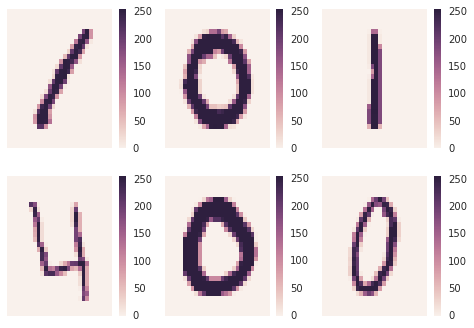

In [27]:
show_instances("features")

## Normalization

In this Section, we will normalize the feature vectors between the 0 and 1 range. We will use Spark's [MinMaxScaler](http://spark.apache.org/docs/latest/ml-features.html#minmaxscaler) to achieve this.

In [34]:
# Clear the dataset in the case you ran this cell before.
dataset = dataset.select("features", "label", "label_encoded")
# Apply MinMax normalization to the features.
scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="features", outputCol="features_normalized")
# Compute summary statistics and generate MinMaxScalerModel.
scaler_model = scaler.fit(dataset)
# Rescale each feature to range [min, max].
dataset = scaler_model.transform(dataset)

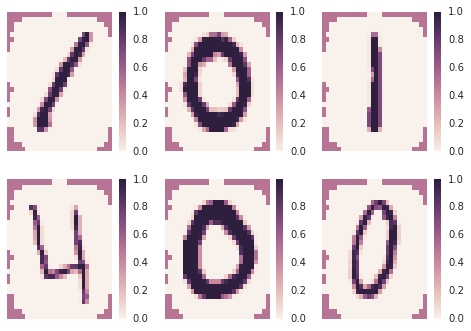

In [35]:
show_instances("features_normalized")

In [37]:
dataset.select("features_normalized").take(1)[0]

Row(features_normalized=DenseVector([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7373, 1.0, 0.3686, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.749, 0.9804, 0.9922, 0.3647, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4824, 0.9725, 

## Model Development

### Multilayer Perceptron

In [38]:
mlp = Sequential()
mlp.add(Dense(512, input_shape=(784,)))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(512))
mlp.add(Activation('relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(10))
mlp.add(Activation('softmax'))

In [39]:
mlp.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           401920      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           262656      dropout_1[0][0]                  
___________________________________________________________________________________________

### Convolutional Network

### Optimizer and Loss

In [40]:
optimizer = 'adagrad'
loss = 'categorical_crossentropy'

## Training

In [41]:
dataset.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: long (nullable = true)
 |-- label_encoded: vector (nullable = true)
 |-- features_normalized: vector (nullable = true)



In [42]:
dataset = dataset.select("features_normalized", "label", "label_encoded")

In [43]:
# Shuffle the dataset.
dataset = shuffle(dataset)

In [44]:
dense_transformer = DenseTransformer(input_col="features_normalized", output_col="features_normalized_dense")
dataset = dense_transformer.transform(dataset)

In [45]:
(training_set, test_set) = dataset.select("features_normalized_dense", "label", "label_encoded").randomSplit([0.7, 0.3])
training_set.cache()
test_set.cache()

DataFrame[features_normalized_dense: vector, label: bigint, label_encoded: vector]

In [46]:
def evaluate_accuracy(model):
    global test_set
    
    # Allocate a Distributed Keras Accuracy evaluator.
    evaluator = AccuracyEvaluator(prediction_col="prediction_index", label_col="label_index")
    # Clear the prediction column from the testset.
    test_set = test_set.select("features_normalized_dense", "label_index", "label")
    # Apply a prediction from a trained model.
    predictor = ModelPredictor(keras_model=trained_model, features_col="features_normalized")
    test_set = predictor.predict(test_set)
    # Allocate an index transformer.
    index_transformer = LabelIndexTransformer(output_dim=nb_classes)
    # Transform the prediction vector to an indexed label.
    test_set = index_transformer.transform(test_set)
    # Fetch the score.
    score = evaluator.evaluate(test_set)
    
    return score

In [50]:
trainer = SingleTrainer(keras_model=mlp, worker_optimizer=optimizer,
                        loss=loss, features_col="features_normalized_dense",
                        label_col="label_encoded", num_epoch=1, batch_size=32)
trained_model = trainer.train(training_set)

In [51]:
print("Training time: " + str(trainer.get_training_time()))

Training time: 27.7797150612
